### Building Bionomial GLM To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Number of emails sent in each subject
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [10]:
#importing libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [11]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")
df.columns = df.columns.str.strip()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent_Date          1279 non-null   object 
 1   Day_of_week        1279 non-null   object 
 2   Category_name      1279 non-null   object 
 3   Main_Vs_REM        1279 non-null   object 
 4   Subject            1279 non-null   object 
 5   Sendings           1279 non-null   int64  
 6   OR                 1279 non-null   float64
 7   Length_Of_subject  1279 non-null   int64  
 8   Personalization    1279 non-null   int64  
 9   Emoji              1279 non-null   int64  
 10  Urgency            1279 non-null   int64  
 11  Tone               1279 non-null   int64  
 12  Price_or_Discount  1279 non-null   int64  
 13  Imperative_Tone    1279 non-null   int64  
 14  Product            1279 non-null   int64  
 15  Month              1279 non-null   int64  
 16  Letter_Count       1279 

In [13]:
columns_to_drop = [ "translation", "CTR clean %","Month"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [14]:
df.columns

Index(['Sent_Date', 'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Subject',
       'Sendings', 'OR', 'Length_Of_subject', 'Personalization', 'Emoji',
       'Urgency', 'Tone', 'Price_or_Discount', 'Imperative_Tone', 'Product',
       'Letter_Count'],
      dtype='object')

In [15]:
# Convert to datetime
df['Sent_Date'] = pd.to_datetime(df['Sent_Date'], errors='coerce')

# Create a Month column (numeric)
df['Month'] = df['Sent_Date'].dt.month


In [16]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)





In [17]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month',
    "Subject"
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Sent_Date          1279 non-null   datetime64[ns]
 1   Day_of_week        1279 non-null   category      
 2   Category_name      1279 non-null   category      
 3   Main_Vs_REM        1279 non-null   category      
 4   Subject            1279 non-null   category      
 5   Sendings           1279 non-null   int64         
 6   OR                 1279 non-null   float64       
 7   Length_Of_subject  1279 non-null   category      
 8   Personalization    1279 non-null   category      
 9   Emoji              1279 non-null   category      
 10  Urgency            1279 non-null   category      
 11  Tone               1279 non-null   category      
 12  Price_or_Discount  1279 non-null   category      
 13  Imperative_Tone    1279 non-null   category      
 14  Product 

In [19]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict





In [20]:

# Set Winsorization thresholds (percentiles)
#lower_pct = 0.01  # 1st percentile
#upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
#columns_to_winsorize = ['Sendings', 'OR']

#for col in columns_to_winsorize:
    #lower = df[col].quantile(lower_pct)
    #upper = df[col].quantile(upper_pct)
    #df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    #print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling


- Confirming that Data is valid for regression models 
 - Cheking correlation 
 - Ckeking multicoliniarity

In [21]:
df.to_csv("my_data.csv", index=False)

### Building bionomial GLM  model 

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


In [23]:
df['opens'] = (df['OR'] * df['Sendings']).round().astype(int)
df['non_opens'] = df['Sendings'] - df['opens']

In [24]:
df = df.sort_values('Sent_Date')
# Define cutoff date (e.g., last 20% of records for testing)
cutoff_index = int(len(df) * 0.8)
train_df = df.iloc[:cutoff_index]
test_df = df.iloc[cutoff_index:]

print(f"Training data: {train_df['Sent_Date'].min().date()} → {train_df['Sent_Date'].max().date()}")
print(f"Testing data:  {test_df['Sent_Date'].min().date()} → {test_df['Sent_Date'].max().date()}")
print(f"\n📊 Train size: {len(train_df)}, Test size: {len(test_df)}")


Training data: 2024-01-01 → 2024-11-02
Testing data:  2024-11-02 → 2024-12-31

📊 Train size: 1023, Test size: 256


In [25]:
categorical_cols = [
      'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month',
    "Subject"
]

# Automatically detect numeric features (excluding target + weight)
numeric_cols = [
    col for col in train_df.select_dtypes(include=[np.number]).columns
    if col not in ['OR', 'Sendings', 'opens', 'non_opens']]


In [26]:
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True, dtype=int)
X_test_cat  = pd.get_dummies(test_df[categorical_cols],  drop_first=True, dtype=int)

X_train_num = train_df[numeric_cols].reset_index(drop=True)
X_test_num  = test_df[numeric_cols].reset_index(drop=True)

X_train = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_num.reset_index(drop=True),  X_test_cat.reset_index(drop=True)], axis=1)

In [27]:


# Ensure all columns numeric (no bool/object left)
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

Here, Sendings are built into y, so you’re automatically weighting each row by its number of trials.

In [28]:
# --- 4. prepare response (two-column) and indices alignment
y_train = train_df[['opens', 'non_opens']].reset_index(drop=True)
y_test  = test_df[['opens', 'non_opens']].reset_index(drop=True)

In [29]:
# Reset indices for everything to avoid index-mismatch errors
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

In [30]:
#add intercept and fit Binomial GLM (uses counts as endog) ---
X_train_const = sm.add_constant(X_train, has_constant='add').astype(float)
X_test_const  = sm.add_constant(X_test,  has_constant='add').astype(float)

In [31]:
glm_binom = sm.GLM(
    y_train,                      
    X_train_const,
    family=sm.families.Binomial()
)
result = glm_binom.fit()
print(result.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['opens', 'non_opens']   No. Observations:                 1023
Model:                                GLM   Df Residuals:                      989
Model Family:                    Binomial   Df Model:                           33
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -69052.
Date:                    Thu, 23 Oct 2025   Deviance:                   1.2841e+05
Time:                            13:03:14   Pearson chi2:                 1.37e+05
No. Iterations:                         6   Pseudo R-squ. (CS):              1.000
Covariance Type:                nonrobust                                         
                                                                                                                                                                          

In [32]:
#predict probabilities on test set ---
# result.predict returns predicted probability of success (open rate)
test_df = test_df.reset_index(drop=True)  # keep row alignment
test_df['pred_open_rate'] = result.predict(X_test_const)

In [33]:
# predicted opens 
test_df['pred_opens'] = (test_df['pred_open_rate'] * test_df['Sendings']).round().astype(int)

In [34]:
# evaluation (use proportions for comparability) ---
# drop any rows with missing actual/predicted (should be none)
eval_df = test_df.dropna(subset=['OR', 'pred_open_rate']).copy()
y_true = eval_df['OR']
y_pred = eval_df['pred_open_rate']

In [35]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
corr, _ = pearsonr(y_true, y_pred)

# McFadden pseudo-R² (note: can be negative if model worse than null)
llf = result.llf
llnull = result.null_deviance / -2.0
pseudo_r2 = 1 - (llf / llnull)

print("\nMODEL PERFORMANCE (Test set)")
print(f"Rows evaluated: {len(eval_df)}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Pearson r: {corr:.4f}")
print(f"McFadden pseudo-R²: {pseudo_r2:.4f}")


MODEL PERFORMANCE (Test set)
Rows evaluated: 256
MAE: 0.0266
RMSE: 0.0359
R²: -0.2979
Pearson r: 0.4581
McFadden pseudo-R²: 0.8135


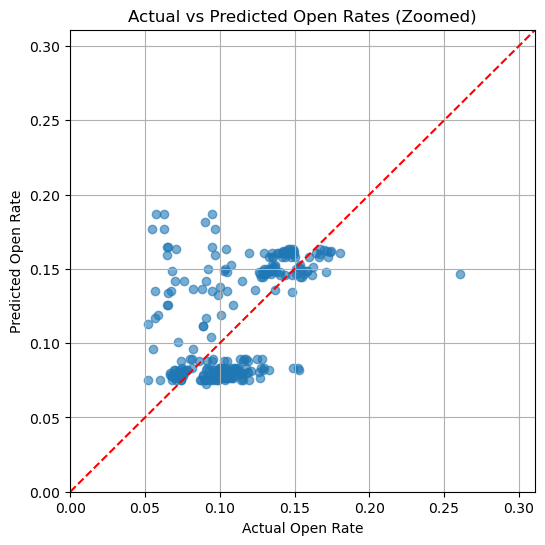

In [36]:
# --- 9. plots (zoomed because your data < 0.5 mostly) ---
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
max_val = max(y_true.max(), y_pred.max())
upper_limit = min(0.6, float(round(max_val + 0.05, 3)))
plt.plot([0, upper_limit], [0, upper_limit], 'r--')
plt.xlim(0, upper_limit)
plt.ylim(0, upper_limit)
plt.xlabel('Actual Open Rate')
plt.ylabel('Predicted Open Rate')
plt.title('Actual vs Predicted Open Rates (Zoomed)')
plt.grid(True)
plt.show()

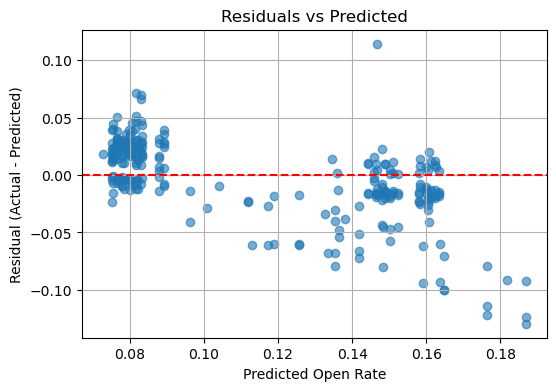

In [37]:
# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Open Rate')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

In [38]:

from IPython.display import display, HTML
import pandas as pd
import numpy as np

# --- Extract coefficients and related stats ---
coef_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Error': result.bse.values,
    'p_value': result.pvalues.values
})

# Add Odds Ratios (exp(coefficient))
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Sort by absolute effect (largest first)
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Keep top 10 (excluding intercept)
top10 = coef_df[coef_df['Feature'] != 'const'].head(10).copy()

# Round for readability
top10['Coefficient'] = top10['Coefficient'].round(4)
top10['Std_Error'] = top10['Std_Error'].round(4)
top10['Odds_Ratio'] = top10['Odds_Ratio'].round(3)
top10['p_value'] = top10['p_value'].apply(lambda x: f"{x:.4f}" if x >= 0.0001 else "<0.0001")

# Display as a neat HTML table
html_table = top10.to_html(
    index=False,
    justify='center',
    border=0,
    classes='table table-striped table-hover',
    escape=False
)

# Add a clean title
display(HTML(f"""
<style>
.table th, .table td {{ text-align: center; padding: 8px; }}
.table th {{ background-color: #f2f2f2; }}
h3 {{ color: #2F4F4F; font-family: Arial; }}
</style>
<h3>📊 Top 10 Most Important Features (by Absolute Coefficient Size)</h3>
{html_table}
"""))



Feature,Coefficient,Std_Error,p_value,Odds_Ratio
Subject_Upp till -63% på favorit Väggdekorationer!,-0.5394,0.0030,<0.0001,0.583
Length_Of_subject_short,-0.4373,0.0018,<0.0001,0.646
Price_or_Discount_yes,-0.3526,0.0015,<0.0001,0.703
Urgency_yes,-0.3448,0.0018,<0.0001,0.708
Subject_Dekorativ inredning för hemmet till de bästa priset,0.3153,0.0038,<0.0001,1.371
Subject_Upp till 58% rabatt på de mest älskade Canvastavlor! 🤩,-0.2882,0.0040,<0.0001,0.750
"Subject_Dina bilder på Canvastavla eller Fotopresenter från 49,50 kr",0.2778,0.0021,<0.0001,1.320
Day_of_week_Sunday,-0.2538,0.0059,<0.0001,0.776
Subject_2 dagar | Canvastavlor från endast 185 kr!,-0.2452,0.0038,<0.0001,0.783
Subject_Hem och livsstil-produkter från 49 kr,-0.2361,0.0023,<0.0001,0.790


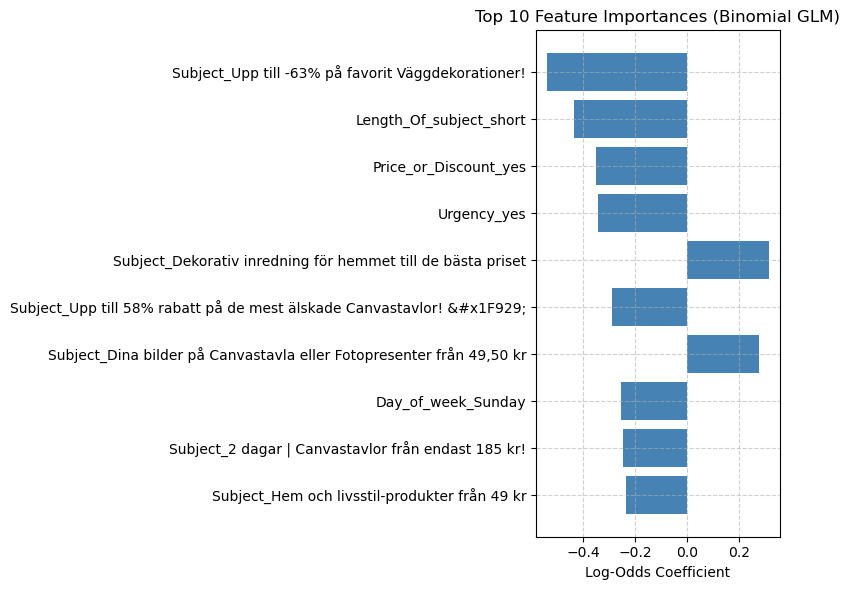

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top10['Feature'], top10['Coefficient'], color='steelblue')
plt.xlabel('Log-Odds Coefficient')
plt.title('Top 10 Feature Importances (Binomial GLM)')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [40]:
import pandas as pd
from IPython.display import display

# --- Extract subject-specific coefficients ---
subject_effects = coef_df[coef_df["Feature"].str.startswith("Subject_")].copy()

# Clean up names
subject_effects["Subject"] = subject_effects["Feature"].str.replace("Subject_", "", regex=False)

# Keep only relevant columns
subject_effects = subject_effects[["Subject", "Coefficient", "Odds_Ratio", "p_value"]]

# Sort by coefficient (impact on open rate)
subject_effects = subject_effects.sort_values("Coefficient", ascending=False)

# Round for clarity
subject_effects["Coefficient"] = subject_effects["Coefficient"].round(4)
subject_effects["Odds_Ratio"] = subject_effects["Odds_Ratio"].round(3)

# --- Show only top 10 subjects ---
top_subjects = subject_effects.head(10).reset_index(drop=True)

print("📬 Top 10 Subjects That INCREASE Open Rate:")
display(top_subjects[["Subject", "Coefficient", "Odds_Ratio"]])



📬 Top 10 Subjects That INCREASE Open Rate:


,Subject,Coefficient,Odds_Ratio
0,Dekorativ inredning för hemmet till de bästa p...,0.3153,1.371
1,Dina bilder på Canvastavla eller Fotopresenter...,0.2778,1.320
2,WOW! Canvastavla 80x60cm för 189 kr,0.2163,1.241
3,Canvastavla 100x75cm för bara 199 kr,0.1910,1.210
4,Personlig väggdekoration till fantastiska priser!,0.1728,1.189
5,Otroligt ✨ 3 XXL-format för 249 kr styck,0.1670,1.182
6,Premiumtryck upp till 78% rabatt!,0.1100,1.116
7,Skynda dig! Väggdekor från endast 39kr!,0.1009,1.106
8,✨ 3 Canvastavlor | 2 dagar | Upp till 54% rabatt!,0.0454,1.046
9,Skynda dig | -54% på XXL-Canvastavla!,0.0008,1.001


# drop Subject Feature 

In [41]:
import pandas as pd
import numpy as np
from scipy import stats

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

In [42]:
# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")

# Now df has Winsorized columns ready for modeling

Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


In [43]:
df['opens'] = (df['OR'] * df['Sendings']).round().astype(int)
df['non_opens'] = df['Sendings'] - df['opens']

In [44]:
df = df.sort_values('Sent_Date')
# Define cutoff date (e.g., last 20% of records for testing)
cutoff_index = int(len(df) * 0.8)
train_df = df.iloc[:cutoff_index]
test_df = df.iloc[cutoff_index:]

print(f"Training data: {train_df['Sent_Date'].min().date()} → {train_df['Sent_Date'].max().date()}")
print(f"Testing data:  {test_df['Sent_Date'].min().date()} → {test_df['Sent_Date'].max().date()}")
print(f"\n📊 Train size: {len(train_df)}, Test size: {len(test_df)}")

Training data: 2024-01-01 → 2024-11-02
Testing data:  2024-11-02 → 2024-12-31

📊 Train size: 1023, Test size: 256


In [45]:
categorical_cols = [
      'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month'
]

# Automatically detect numeric features (excluding target + weight)
numeric_cols = [
    col for col in train_df.select_dtypes(include=[np.number]).columns
    if col not in ['OR', 'Sendings', 'opens', 'non_opens']]


In [46]:
X_train_cat = pd.get_dummies(train_df[categorical_cols], drop_first=True, dtype=int)
X_test_cat  = pd.get_dummies(test_df[categorical_cols],  drop_first=True, dtype=int)

X_train_num = train_df[numeric_cols].reset_index(drop=True)
X_test_num  = test_df[numeric_cols].reset_index(drop=True)

X_train = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_num.reset_index(drop=True),  X_test_cat.reset_index(drop=True)], axis=1)

In [47]:


# Ensure all columns numeric (no bool/object left)
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

In [48]:
# Reset indices for everything to avoid index-mismatch errors
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

In [49]:
#add intercept and fit Binomial GLM (uses counts as endog) ---
X_train_const = sm.add_constant(X_train, has_constant='add').astype(float)
X_test_const  = sm.add_constant(X_test,  has_constant='add').astype(float)

In [50]:
glm_binom = sm.GLM(
    y_train,                      
    X_train_const,
    family=sm.families.Binomial()
)
result = glm_binom.fit()
print(result.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['opens', 'non_opens']   No. Observations:                 1023
Model:                                GLM   Df Residuals:                      998
Model Family:                    Binomial   Df Model:                           24
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:            -1.2727e+05
Date:                    Thu, 23 Oct 2025   Deviance:                   2.4484e+05
Time:                            13:03:18   Pearson chi2:                 2.58e+05
No. Iterations:                         6   Pseudo R-squ. (CS):              1.000
Covariance Type:                nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [51]:
#predict probabilities on test set ---
# result.predict returns predicted probability of success (open rate)
test_df = test_df.reset_index(drop=True)  # keep row alignment
test_df['pred_open_rate'] = result.predict(X_test_const)

In [52]:
# predicted opens 
test_df['pred_opens'] = (test_df['pred_open_rate'] * test_df['Sendings']).round().astype(int)

In [53]:
# evaluation (use proportions for comparability) ---
# drop any rows with missing actual/predicted (should be none)
eval_df = test_df.dropna(subset=['OR', 'pred_open_rate']).copy()
y_true = eval_df['OR']
y_pred = eval_df['pred_open_rate']

In [54]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
corr, _ = pearsonr(y_true, y_pred)

# McFadden pseudo-R² (note: can be negative if model worse than null)
llf = result.llf
llnull = result.null_deviance / -2.0
pseudo_r2 = 1 - (llf / llnull)

print("\nMODEL PERFORMANCE (Test set)")
print(f"Rows evaluated: {len(eval_df)}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Pearson r: {corr:.4f}")
print(f"McFadden pseudo-R²: {pseudo_r2:.4f}")


MODEL PERFORMANCE (Test set)
Rows evaluated: 256
MAE: 0.0297
RMSE: 0.0427
R²: -0.8701
Pearson r: 0.2326
McFadden pseudo-R²: 0.6563


C:\Users\TOWER-PC\AppData\Local\Temp\ipykernel_5160\1161176239.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_cal.groupby('bin').agg(


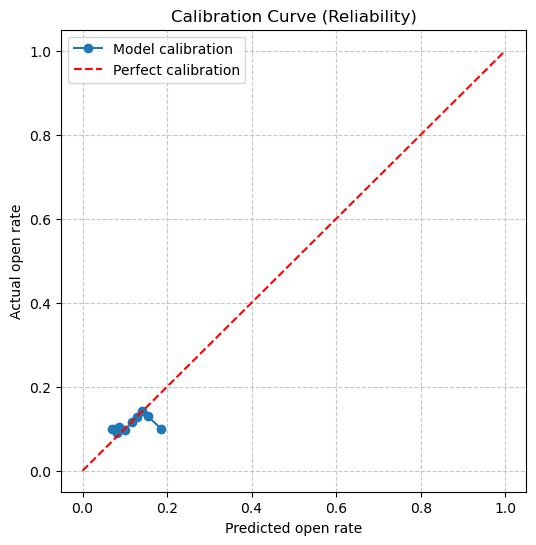


📏 Mean Absolute Error (MAE): 0.0297

🚀 Top-decile lift: 0.90x
   (Top 10% avg open rate = 0.099, overall avg = 0.110)

📊 Top 20 Drivers (with 95% Confidence Intervals):

                      Feature  Coefficient  Lower_CI  Upper_CI  Odds_Ratio  \
17    Length_Of_subject_short    -0.494804 -0.501523 -0.488085    0.609690   
14      Price_or_Discount_yes    -0.471737 -0.474867 -0.468606    0.623918   
12                Urgency_yes    -0.425822 -0.428350 -0.423295    0.653232   
8   Category_name_NL Interval    -0.248131 -0.255058 -0.241204    0.780258   
7       Day_of_week_Wednesday     0.229156  0.225976  0.232335    1.257538   
15        Imperative_Tone_yes    -0.224439 -0.231065 -0.217814    0.798964   
6         Day_of_week_Tuesday     0.193370  0.182242  0.204498    1.213332   
3        Day_of_week_Saturday    -0.186853 -0.196477 -0.177229    0.829565   
5        Day_of_week_Thursday     0.175928  0.161914  0.189941    1.192352   
2          Day_of_week_Monday     0.094781  0.084

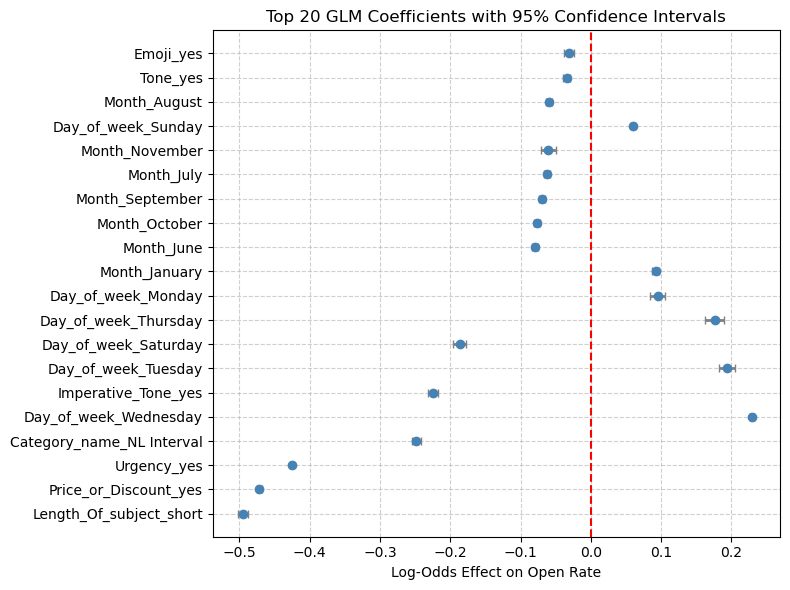

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ========== 1️⃣ CALIBRATION CURVE (reliability plot) ==========

y_true = test_df['OR']        # actual open rate
y_pred = test_df['pred_open_rate']  # predicted open rate (probability)

# Remove NaNs for safe plotting
mask = (~y_true.isna()) & (~y_pred.isna())
y_true = y_true[mask]
y_pred = y_pred[mask]

# ✅ FIX: manual calibration for continuous proportions
df_cal = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_cal['bin'] = pd.qcut(df_cal['y_pred'], q=10, duplicates='drop')

calibration = df_cal.groupby('bin').agg(
    prob_pred=('y_pred', 'mean'),
    prob_true=('y_true', 'mean'),
    count=('y_true', 'size')
).reset_index()

plt.figure(figsize=(6, 6))
plt.plot(calibration['prob_pred'], calibration['prob_true'], 'o-', label='Model calibration')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')
plt.xlabel('Predicted open rate')
plt.ylabel('Actual open rate')
plt.title('Calibration Curve (Reliability)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ========== 2️⃣ MAE ==========
mae = mean_absolute_error(y_true, y_pred)
print(f"\n📏 Mean Absolute Error (MAE): {mae:.4f}")

# ========== 3️⃣ TOP-DECILE LIFT ==========
df_eval = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
df_eval = df_eval.sort_values('y_pred', ascending=False)
cutoff = int(0.1 * len(df_eval))

overall_mean = df_eval['y_true'].mean()
top_decile_mean = df_eval.head(cutoff)['y_true'].mean()
lift = top_decile_mean / overall_mean

print(f"\n🚀 Top-decile lift: {lift:.2f}x")
print(f"   (Top 10% avg open rate = {top_decile_mean:.3f}, overall avg = {overall_mean:.3f})")

# ========== 4️⃣ DRIVERS (GLM coefficients with 95% CI) ==========
coef_summary = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Err': result.bse.values,
    'p_value': result.pvalues.values
})
coef_summary['Lower_CI'] = coef_summary['Coefficient'] - 1.96 * coef_summary['Std_Err']
coef_summary['Upper_CI'] = coef_summary['Coefficient'] + 1.96 * coef_summary['Std_Err']
coef_summary['Odds_Ratio'] = np.exp(coef_summary['Coefficient'])
coef_summary['Lower_OR'] = np.exp(coef_summary['Lower_CI'])
coef_summary['Upper_OR'] = np.exp(coef_summary['Upper_CI'])

coef_summary = coef_summary.reindex(coef_summary['Coefficient'].abs().sort_values(ascending=False).index)
top_coef = coef_summary[coef_summary['Feature'] != 'const'].head(20)

print("\n📊 Top 20 Drivers (with 95% Confidence Intervals):\n")
print(top_coef[['Feature', 'Coefficient', 'Lower_CI', 'Upper_CI', 'Odds_Ratio', 'p_value']])

# ========== 5️⃣ OPTIONAL: Visualize Drivers ==========
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=top_coef['Coefficient'],
    y=top_coef['Feature'],
    xerr=1.96 * top_coef['Std_Err'],
    fmt='o', color='steelblue', ecolor='gray', elinewidth=2, capsize=3
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Top 20 GLM Coefficients with 95% Confidence Intervals')
plt.xlabel('Log-Odds Effect on Open Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [56]:
# --- Top-decile lift ---
threshold = np.percentile(eval_df['pred_open_rate'], 90)
top_decile = eval_df[eval_df['pred_open_rate'] >= threshold]

overall_mean = eval_df['OR'].mean()
top_mean = top_decile['OR'].mean()
lift = top_mean / overall_mean

print("=== Top-decile lift (GLM predictions) ===")
print(f"Overall average OR: {overall_mean:.4f}")
print(f"Top 10% predicted average OR: {top_mean:.4f}")
print(f"Lift: {lift:.2f}×")


=== Top-decile lift (GLM predictions) ===
Overall average OR: 0.1101
Top 10% predicted average OR: 0.0991
Lift: 0.90×


In [57]:
import pandas as pd
import numpy as np

def predict_open_rate_glm(result, new_data):
    """
    Predict open rates for new email campaigns using a trained Binomial GLM model.
    'Sendings' is not used as a predictor — it is used to compute expected opens.
    """

    X_new = new_data.copy()

    # 1️⃣ Define categorical columns
    categorical_features = [
        'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Length_Of_subject',
        'Personalization', 'Emoji', 'Urgency', 'Tone',
        'Price_or_Discount', 'Imperative_Tone', 'Product', 'Month'
    ]

    # 2️⃣ One-hot encode like training
    X_new_encoded = pd.get_dummies(X_new, columns=categorical_features, drop_first=False)

    # 3️⃣ Add const if missing
    if 'const' not in X_new_encoded.columns:
        X_new_encoded['const'] = 1

    # 4️⃣ Ensure all model columns exist
    for col in result.params.index:
        if col not in X_new_encoded.columns:
            X_new_encoded[col] = 0

    # 5️⃣ Reorder columns to match model
    X_new_encoded = X_new_encoded[result.params.index].astype(float)

    # 6️⃣ Predict open rate (0–1)
    X_new["Predicted_Open_Rate"] = result.predict(X_new_encoded)

    # 7️⃣ Compute expected opens if Sendings is given
    if "Sendings" in X_new.columns:
        X_new["Expected_Opens"] = X_new["Predicted_Open_Rate"] * X_new["Sendings"]

    # 8️⃣ Display compact result
    display(X_new[[
        "Day_of_week", "Category_name", "Main_Vs_REM",
        "Tone", "Personalization", "Emoji",
        "Price_or_Discount", "Sendings",
        "Predicted_Open_Rate", "Expected_Opens"
    ]].round(3))

    return X_new


In [58]:
new_data = pd.DataFrame({
    'Day_of_week': ['Monday', 'Thursday'],
    'Category_name': ['NL Interval', 'NL Interval'],
    'Main_Vs_REM': ['MAIN', 'MAIN'],
    'Personalization': ['no', 'no'],
    'Emoji': ['yes', 'no'],
    'Urgency': ['no', 'yes'],
    'Tone': ['yes', 'no'],
    'Price_or_Discount': ['yes', 'no'],
    'Imperative_Tone': ['no', 'yes'],
    'Product': ['yes', 'no'],
    'Length_Of_subject': ['short', 'long'],
    'Month': ['March', 'September'],
    'Letter_Count': [20, 15],
    'Sendings': [500, 50000]
})

preds = predict_open_rate_glm(result, new_data)

,Day_of_week,Category_name,Main_Vs_REM,Tone,Personalization,Emoji,Price_or_Discount,Sendings,Predicted_Open_Rate,Expected_Opens
0,Monday,NL Interval,MAIN,yes,no,yes,yes,500,0.138,68.791
1,Thursday,NL Interval,MAIN,no,no,no,no,50000,0.204,10192.386


In [59]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# === Interactive GLM Prediction App ===

def glm_predictor_widget(result):

    # 1️⃣ Define all feature options (from your training data)
    feature_options = {
        'Day_of_week': ['Sunday', 'Saturday', 'Wednesday', 'Friday', 'Tuesday', 'Monday', 'Thursday'],
        'Category_name': ['NL Interval'],
        'Main_Vs_REM': ['MAIN'],
        'Length_Of_subject': ['short', 'long'],
        'Personalization': ['yes', 'no'],
        'Emoji': ['yes', 'no'],
        'Urgency': ['no', 'yes'],
        'Tone': ['yes', 'no'],
        'Price_or_Discount': ['yes', 'no'],
        'Imperative_Tone': ['no', 'yes'],
        'Product': ['no', 'yes'],
        'Month': ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November']
    }

    # 2️⃣ Create dropdowns and numeric inputs
    widgets_dict = {
        col: widgets.Dropdown(options=vals, description=col, layout=widgets.Layout(width='300px'))
        for col, vals in feature_options.items()
    }

    letter_count = widgets.IntSlider(
        value=40, min=0, max=70, step=1,
        description='Letter_Count', continuous_update=False, layout=widgets.Layout(width='400px')
    )

    sendings = widgets.IntText(value=10000, description='Sendings', layout=widgets.Layout(width='300px'))

    predict_button = widgets.Button(description="📬 Predict", button_style='primary', layout=widgets.Layout(width='150px'))

    output = widgets.Output()

    # 3️⃣ Define prediction logic
    def on_predict_clicked(_):
        with output:
            clear_output()

            # Collect inputs into DataFrame
            new_data = pd.DataFrame([{
                **{col: w.value for col, w in widgets_dict.items()},
                'Letter_Count': letter_count.value,
                'Sendings': sendings.value
            }])

            # One-hot encode as in training
            categorical_features = list(feature_options.keys())
            X_new_encoded = pd.get_dummies(new_data, columns=categorical_features, drop_first=False)

            # Add const if missing
            if 'const' not in X_new_encoded.columns:
                X_new_encoded['const'] = 1

            # Align with model columns
            for col in result.params.index:
                if col not in X_new_encoded.columns:
                    X_new_encoded[col] = 0

            X_new_encoded = X_new_encoded[result.params.index].astype(float)

            # Predict open rate
            predicted_or = result.predict(X_new_encoded)[0]
            expected_opens = predicted_or * new_data["Sendings"].iloc[0]

            print("📊 **Prediction Result**")
            print(f"Predicted Open Rate: {predicted_or * 100:.2f}%")
            print(f"Expected Opens: {expected_opens:.0f} (out of {new_data['Sendings'].iloc[0]} sent)")

            display(new_data)

    predict_button.on_click(on_predict_clicked)

    # 4️⃣ Layout
    form_items = [widgets.HBox([widgets_dict[c1], widgets_dict[c2]]) 
                  for c1, c2 in zip(list(feature_options.keys())[::2], list(feature_options.keys())[1::2])]

    form = widgets.VBox(form_items + [letter_count, sendings, predict_button, output])
    display(form)


# === Example usage ===
glm_predictor_widget(result)


Summary:
Your model is moderately reliable — it clearly captures some meaningful signal (likely category, personalization, or tone effects), but not the full complexity of open-rate behavior (which depends heavily on audience, time, and context).

it is good for directional insights (e.g., which features increase open rate) and rough forecasting, but not for precise prediction (e.g., campaign-level open rate within ±1%).